# Grab AI Challenge: Safety

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import math
import glob 
import sklearn
from sklearn.model_selection import train_test_split

## Loading the Data

In [2]:
# Loading the features file
path = r'./safety/features/'
all_files = glob.glob(path + "/*.csv")

df = pd.concat(pd.read_csv(f) for f in all_files)

In [3]:
# Loading the labels file
datalabels = pd.read_csv("./safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [2]:
# # Loading full dataset that I've pickled;
# import pickle

## load features data
# fpath = "./safety/features/sorted.pkl"
# df = pickle.load(open(fpath,'rb'))

## load labels data


## Cleaning the Data
- Format all the features properly (booking ID as string not integer)
- Handle any duplicacy/NA/zero values.
    - Some booking IDs are repeated in the labels dataset. 

In [4]:
#convert bookingID to a string object instead of an integer
df.bookingID = df.bookingID.apply(str)
datalabels.bookingID = datalabels.bookingID.apply(str)
df.dtypes

bookingID          object
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtype: object

In [5]:
pd.options.display.float_format = '{:20,.2f}'.format # formatting
df.describe() 

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,"16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00","16,135,561.00"
mean,11.61,168.97,0.07,4.47,0.89,-0.00,0.00,-0.00,"3,803.48",9.01
std,86.92,107.30,1.42,8.13,3.25,0.14,0.34,0.15,"1,436,686.49",8.11
min,0.75,0.00,-78.42,-72.99,-78.45,-48.46,-74.89,-53.55,0.00,-2.00
25%,3.90,78.00,-0.51,-2.02,-0.93,-0.03,-0.03,-0.02,241.00,1.02
50%,4.25,168.87,0.06,9.08,0.78,-0.00,0.00,-0.00,520.00,7.53
75%,8.00,262.98,0.64,9.71,2.75,0.02,0.03,0.02,863.00,15.48
max,"6,070.10",360.00,66.87,75.06,78.06,39.84,80.31,66.30,"1,495,796,757.00",148.02


Remove duplicate labels

In [9]:
unique_labels = datalabels.bookingID.value_counts()

print("There are {} unique labels, \
but a total of {} records in the labels dataset".format(
    len(unique_labels), len(datalabels)))

There are 20000 unique labels, but a total of 20018 records in the labels dataset


In [11]:
# identify the duplicate in the labels dataset which have different labels 
dups = pd.concat(g for _,g in datalabels.groupby("bookingID") if len(g)>1)
dups.drop_duplicates # in case they have duplicate bookingID but same label
print(dups)

           bookingID  label
12463             13      0
12602             13      1
2351    154618822837      1
5295    154618822837      0
6212    223338299461      0
11215   223338299461      1
6121    395136991308      1
19936   395136991308      0
8472    403726925929      0
17623   403726925929      1
2858    455266533495      1
10778   455266533495      0
11058   481036337234      1
18027   481036337234      0
16462   515396075694      0
17843   515396075694      1
10880   695784702084      0
17001   695784702084      1
11133   919123001348      1
18951   919123001348      0
2721    970662608932      0
13634   970662608932      1
6168   1279900254294      1
6210   1279900254294      0
3068   1348619731077      1
16990  1348619731077      0
9979   1391569403991      0
14942  1391569403991      1
9483   1408749273124      0
16340  1408749273124      1
1256   1511828488211      1
6516   1511828488211      0
1059   1632087572573      1
14432  1632087572573      0
13688  1649267441751

In [12]:
# remove duplicates from labels
labels_clean = datalabels[~datalabels.bookingID.isin(dups.bookingID)].copy()
# remove duplicates from features
df_clean = df[~df.bookingID.isin(dups.bookingID)].copy()

In [17]:
df_clean.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1194000908341,4.00,203.00,1.00,9.74,-0.79,-0.07,0.02,0.04,246.00,6.48
1,1099511627891,3.00,311.00,0.45,9.27,3.10,0.01,0.00,-0.00,66.00,0.34
2,962072674446,10.00,142.81,0.02,-8.04,-4.96,0.00,-0.01,0.01,"1,552.00",2.05
3,1142461300867,8.00,171.21,-0.29,-8.30,-3.05,0.03,0.05,0.03,277.00,17.61
4,412316860548,19.38,0.00,0.68,8.85,1.85,-0.01,0.00,0.00,148.00,0.00


In [46]:
# df_clean.loc[df_clean.second == 0].groupby('bookingID').bookingID.nunique() > 1
duplicated_features = df_clean[df_clean.duplicated()]
duplicated_features

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed


In [47]:
duplicated_seconds = df_clean[df_clean.duplicated(['bookingID','second'])]
duplicated_seconds

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed


Checked: There are no further duplicates in the df_clean dataset. Otherwise, we would remove them in the same way as removing the bookingids with duplicated labels. 

#### Accuracy 
Typically, GPS-enabled smartphones are accurate up to 4.9m [[1](https://www.gps.gov/systems/gps/performance/accuracy/)]. This should be case for our dataset as well, since most Grab drivers use their personal smart devices to track the GPS.

In [50]:
df_clean.Accuracy.describe()

count          16,135,561.00
mean                   11.61
std                    86.92
min                     0.75
25%                     3.90
50%                     4.25
75%                     8.00
max                 6,070.10
Name: Accuracy, dtype: float64

In [52]:
# Get the average accuracy for each trip: 
mean_acc = df_clean.groupby('bookingID').Accuracy.mean()
mean_acc.describe()

count              20,000.00
mean                   10.57
std                    38.84
min                     1.63
25%                     4.08
50%                     5.32
75%                     9.31
max                 1,520.83
Name: Accuracy, dtype: float64

Looking at the spread of the mean accuracy per trip in our dataset, we can consider keeping trips with average accuracy > 10m.

However, this is removing almost 26% of our dataset. We might want to reduce it even further. 

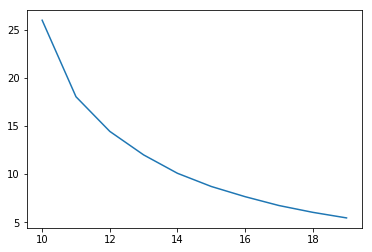

In [80]:
cutoff_range = range(10,20)
ls = []
for cutoff in cutoff_range:
    ls.append(len(mean_acc[mean_acc > cutoff]) / len(mean_acc[mean_acc <= cutoff]) * 100)

plt.plot(cutoff_range,ls)

### EDA

For a single sample of a dangerous drive (label 1):

In [97]:
id_1 = df_clean['bookingID'].iloc[0]
labels_clean[labels_clean.bookingID==id_1]

,bookingID,label
13865,1194000908341,1


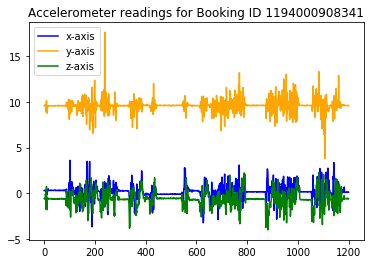

In [99]:
df1 = df_clean[df_clean['bookingID']==id_1].sort_values('second')
seconds = df1['second']
acceleration_x = df1['acceleration_x']
acceleration_y = df1['acceleration_y']
acceleration_z = df1['acceleration_z']
plt.plot(seconds, acceleration_x, color='blue', label='x-axis')
plt.plot(seconds, acceleration_y, color='orange', label='y-axis')
plt.plot(seconds, acceleration_z, color='green', label='z-axis')
plt.title("Accelerometer readings for Booking ID {}".format(id_1))
plt.legend(loc='best')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

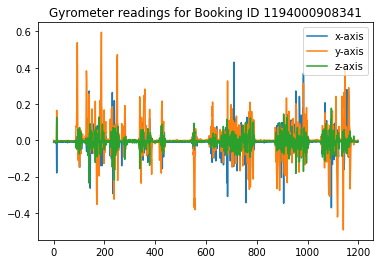

In [100]:
gyro = {}
xyz = ['x','y','z']

for ax in xyz:
    gyro["gyro_{0}".format(ax)] = df1["gyro_{0}".format(ax)]
    plt.plot(seconds, df1["gyro_{0}".format(ax)], label="{0}-axis".format(ax))

plt.title("Gyrometer readings for Booking ID {}".format(id_1))

plt.legend(loc='upper right')
plt.show

In [101]:
df1.describe()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,"1,200.00","1,200.00","1,200.00","1,200.00","1,200.00","1,200.00","1,200.00","1,200.00","1,200.00","1,200.00"
mean,4.29,72.95,0.16,9.61,-0.63,-0.01,0.00,-0.01,599.50,6.69
std,1.45,87.09,0.78,0.71,0.83,0.06,0.09,0.03,346.55,7.71
min,3.00,0.00,-3.66,3.80,-3.99,-0.37,-0.49,-0.24,0.00,0.00
25%,3.34,0.00,-0.10,9.50,-0.92,-0.02,-0.01,-0.01,299.75,0.00
50%,3.90,49.50,0.17,9.59,-0.61,-0.01,-0.00,-0.01,599.50,3.51
75%,4.25,119.00,0.41,9.70,-0.36,-0.00,0.01,-0.00,899.25,12.17
max,12.00,359.00,3.60,17.58,2.27,0.43,0.60,0.18,"1,199.00",27.73


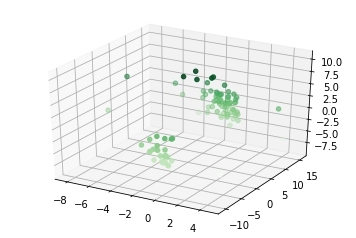

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')
## This takes way too long to load. 
# x_a = df['acceleration_x']
# y_a = df['acceleration_y']
# z_a = df['acceleration_z']
# ax.scatter3D(x_a,y_a,z_a,c=z_a,cmap='Greens')
# x_b = df['gyro_x']
# y_b = df['gyro_y']
# z_b = df['gyro_z']
# ax.scatter3D(x_b,y_b,z_b,c=z_b,cmap='Blues')

x_test = df['acceleration_x'].head(100)
y_test = df['acceleration_y'].head(100)
z_test = df['acceleration_z'].head(100)
ax.scatter3D(x_test,y_test,z_test, c=z_test, cmap='Greens')

## Feature Engineering
### Group by Booking ID, Sort by Time 


In [82]:
df_sorted = df_clean.sort_values(['bookingID','second']).copy()
df_sorted.head(20)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1153972,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
712971,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
167611,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
436147,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
1423207,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454
357335,0,8.0,143.298294,-0.608313,-9.539658,-1.794583,-0.007538,-0.023838,0.018068,5.0,0.228454
1413389,0,8.0,143.298294,-0.867758,-9.698615,-1.615439,0.022728,-0.012178,0.005982,6.0,0.228454
767009,0,8.0,143.298294,-1.050790,-9.745270,-1.411771,0.027603,0.001841,0.000904,7.0,0.228454
1312324,0,8.0,143.298294,-0.721213,-9.960004,-1.202271,0.001864,-0.007702,0.014018,8.0,0.228454
945598,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454


In [83]:
# codeout
df_sorted.to_pickle('./safety/features/sorted.pkl')

In [84]:
df_mini = df_sorted.head(int(len(df_sorted)*0.1)).copy()

In [85]:
df_mini = df_mini.reset_index()

In [86]:
lastval = df_mini[(df_mini.bookingID==df_mini.iloc[-1,1]) & (df_mini.second == 0.00)].index[0]
df_mini = df_mini.iloc[:lastval,:]

In [87]:
from tsfresh import extract_features
extracted_features = extract_features(df_mini, column_id="bookingID", column_sort="second")

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/geri/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/geri/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/geri/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/geri/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/geri/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/distribution.py", line 38, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
 

KeyboardInterrupt: 

  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/distribution.py", line 37, in <genexpr>
    results = (map_function(chunk, **kwargs) for chunk in chunk_list)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/extraction.py", line 358, in _do_extraction_on_chunk
    return list(_f())
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/extraction.py", line 358, in _do_extraction_on_chunk
    return list(_f())
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/extraction.py", line 350, in _f
    result = [("", func(data))]
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/extraction.py", line 350, in _f
    result = [("", func(data))]
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py", line 1501, in sample_entropy
    temp_ts_length = min(sample_length, curr[jj])
  File 

### Time series 
Using the `tsfresh` package [[3](https://tsfresh.readthedocs.io/en/latest/text/quick_start.html)] to generate features from a time series.

In [ ]:
# package takes really long, might just end up doing somethign else...


### Accelerometer and Gyroscope Readings 
3-axis accelerometer is highly useful for determining acceleration and orientation already. However, Gyroscope readings can be used to smooth out any errors in accelerometer readings. [2](http://www.starlino.com/imu_guide.html)

In [48]:
# # create a new column for R acceleration
# df.Racc = math.sqrt(df.acceleration_x**2 +df.acceleration_y**2  +df.acceleration_z**2 )

# normalize ? 
# does it match GPS bearing?

# repeat creating a new column for gyroscope readings?

## Splitting the Data
We will do a 70% train 30% test split.

In [19]:
# Join the labels to the main df.
data = pd.merge(df,datalabels, how='left',on='bookingID')

In [20]:
data.shape

(16154418, 12)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df, datalabels, test_size=0.3, random_state=2019)

In [21]:
data.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,"16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00","16,154,418.00"
mean,"818,529,450,874.48",11.61,168.98,0.07,4.46,0.89,-0.00,0.00,-0.00,"3,799.90",9.01,0.31
std,"495,337,696,790.59",86.87,107.30,1.42,8.13,3.25,0.14,0.34,0.15,"1,435,847.73",8.11,0.46
min,0.00,0.75,0.00,-78.42,-72.99,-78.45,-48.46,-74.89,-53.55,0.00,-2.00,0.00
25%,"377,957,122,222.00",3.90,78.00,-0.51,-2.11,-0.93,-0.03,-0.03,-0.02,241.00,1.02,0.00
50%,"807,453,851,670.00",4.25,168.96,0.06,9.08,0.77,-0.00,0.00,-0.00,520.00,7.53,0.00
75%,"1,254,130,450,454.00",8.00,263.00,0.64,9.71,2.75,0.02,0.03,0.02,863.00,15.48,1.00
max,"1,709,396,983,975.00","6,070.10",360.00,66.87,75.06,78.06,39.84,80.31,66.30,"1,495,796,757.00",148.02,1.00
